In [128]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, glob
from scipy.optimize import minimize


# psuedo

```
1. there's a uniform dist of stim, ranging from -.38 to .38, inclusive, in multiples of .04

2. there is div_pos = 0

3. asymmetric #coins are gained or lost based whether output is on the same side of div_pos as stim_pos. specifically, payoffs:
        true_neg (tn), true_pos (tp), false_neg (fn), false_pos (fp) = 1, 3, -1, -3

4. there is a response bias towards the boundary, bound_bias. ignore this for now. 

5. resp depends on noised_stim_pos, PAYOFFS?, and risk_prone (seeking if > 0, averse if < 0). specifically,

        generate agents with risk_prone vals -1, -.6, -.2, .2, .6, 1
        rep = noised_stim_pos

        for stim in stim_pos:
                
                if risk_prone > 0: # risk seeking
                        
                        if rep < 0:
                                p_seek increases as rep becomes closer to 0, with faster rises for greater |risk_prone|
                                resp = err, with prob = p_seek
                                          rep, with prob = 1 - p_seek

                if risk_prone < 0: # risk averse
                        
                        if rep > 0:
                                p_avert increases as rep becomes closer to 0, with faster rises for greater |risk_prone|
                                resp = -err, with prob = p_avert
                                          rep, with prob = 1 - p_avert


plot hist of noised_stim_pos
for each agent across 2*3 subplots, plot stim_pos vs resp

# note: in the near future, could frame this as a maximizing coins, minimizing switching, and minimizing distance from boundary problem

                # pull towards boundary, with stronger pulls for farther positions
                rep = noised_stim_pos/(noised_stim_pos * bound_bias)

# 1.

In [ ]:
def simulate(fake_stim, noise = .2):
    fake_resp = fake_stim + np.random.normal(0, noise, len(fake_stim))
    return fake_resp

def loglik(noise, fake_stim, fake_resp):
    # Compute the log-likelihood of the data given the model
    resid = fake_resp - fake_stim
    # essentialy p(fake_resp|fake_stim), which takes a particular formula for gaussians
    # then multiply for all fake_stim, and sum-log it (easier)
    ll = -0.5 * np.sum(np.log(2*np.pi*noise**2) + (resid**2)/(noise**2))
    return ll

def fit(fake_stim, fake_resp, init_noise=0.5):
    # Fit the model parameters to the data by minimizing the negative log-likelihood
    nll = lambda sigma: -loglik(sigma[0], fake_stim, fake_resp)
    result = minimize(nll, [init_noise], bounds=[(1e-6, None)])
    return result.x[0] # first & only param

# fake param recovery
fake_stim = np.arange(-0.38, 0.381, 0.04)
fake_stim = np.tile(fake_stim, 50)
true_noise = 0.2

fake_resp = simulate(fake_stim, noise=true_noise)
est_noise = fit(fake_stim, fake_resp)
print("True:", true_noise, "Est:", est_noise)

True: 0.2 Est: 0.2066596528635358


real data

In [138]:
df = pd.read_csv('../results/all_subjs_clean.csv')

stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values

est_noise = fit(stim, resp)
print("Estimated:", est_noise)

Estimated: 0.15636808644191916


# 2.

models

In [144]:
def model1(params, stim):
    '''Simple Gaussian noise: predicts responses as Normal(stim, sigma).'''
    sigma = params[0]
    mu = stim
    return mu, np.full_like(stim, sigma)

def model2(params, stim):
    '''Gaussian noise + bias: Normal(stim + bias, sigma).'''
    sigma, bias = params
    mu = stim + bias
    return mu, np.full_like(stim, sigma)

fitting & comparing

In [145]:
def loglik(model, params, stim, resp):
    '''Log-likelihood for Gaussian continuous responses.'''
    mu, sigma = model(params, stim)
    resid = resp - mu
    ll = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (resid**2)/(sigma**2))
    return ll

def fit_model(model, stim, resp, init_params, bounds):
    '''Fit a model to the data by minimizing the negative log-likelihood.'''
    nll = lambda theta: -loglik(model, theta, stim, resp)
    result = minimize(nll, init_params, bounds=bounds)
    return result.x, -result.fun

def bic(loglik, num_params, num_trials):
    '''Bayesian Information Criterion (BIC) for model comparison.'''
    return -2*loglik + num_params * np.log(num_trials)


doing

In [159]:
# fake data
np.random.seed(0)
stim = np.tile( np.linspace(-0.38, 0.38, 20), 20) # repeat each stim 20x
true_sigma, true_bias = 0.2, 0.1
resp = stim + true_bias + np.random.normal(0, true_sigma, len(stim))

# real data
stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values

# FITTING
fits = []

# noise model
params1, ll1 = fit_model(model1, stim, resp, init_params=[0.5], bounds=[(1e-6,None)])
bic1 = bic(ll1, len(params1), len(stim))
fits.append({"model":"noise","params":params1,"LL":ll1,"BIC":bic1})
# fits.append(f'noise_model\nparams:{params1}\nLL:{ll1}\nBIC:{bic1}')

# bias + noise model
params2, ll2 = fit_model(model2, stim, resp, init_params=[0.5,0], bounds=[(1e-6,None),(-1,1)])
bic2 = bic(ll2, len(params2), len(stim))
fits.append({"model":"noise + bias","params":params2,"LL":ll2,"BIC":bic2})

# Sort by BIC
fits_sorted = sorted(fits, key=lambda x: x["BIC"])
fits_sorted

[{'model': 'noise',
  'params': array([0.15636809]),
  'LL': np.float64(628.7098465053831),
  'BIC': np.float64(-1250.1472946181962)},
 {'model': 'noise + bias',
  'params': array([ 0.15621149, -0.00699745]),
  'LL': np.float64(630.1530342457262),
  'BIC': np.float64(-1245.7612717063123)}]

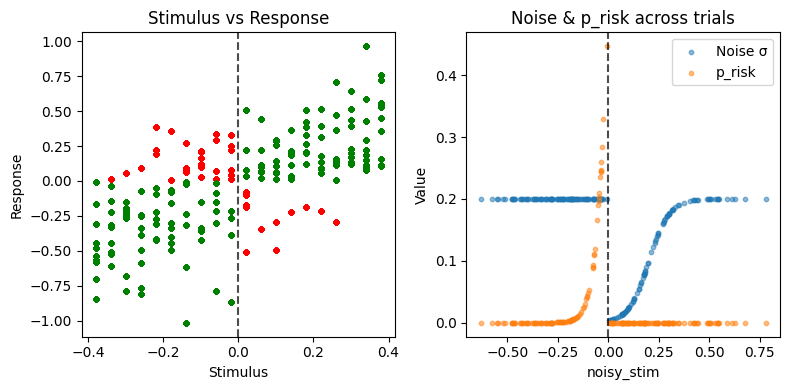

In [127]:
from scipy.special import expit

# Random number generator (fix seed for reproducibility)
rng = np.random.default_rng(0)

def simulate_responses(n_repeats=10, stim_noise=0.2, delta=0.05, k_p=30, k_sigma=20):
    """
    Simulate responses for 20 stimulus positions around divider.
    
    Parameters
    ----------
    n_repeats : int
        Number of repeats per stimulus position
    stim_noise : float
        Base motor noise (larger = noisier responses)
    delta : float
        Shift added when risk bias triggers (left side, towards divider)
    k_p : float
        Steepness of logistic for risk probability
    k_sigma : float
        Steepness of logistic for noise decay on right side
    """
    
    # --- 1. Stimulus grid (20 values from -0.38 to 0.38) ---
    stim_values = np.arange(-0.38, 0.381, 0.04)
    stim = np.tile(stim_values, n_repeats)   # repeat each stim
    n_trials = stim.size
    div = 0
    
    # --- 2. Internal noisy perception of stim ---
    noisy_stim = stim + rng.normal(0, stim_noise, n_trials)
    
    # --- 3. Risk probability (only for noisy_stim < divider) ---
    p_risk = np.where(noisy_stim < div, expit(k_p*(noisy_stim - div)), 0)
    
    # --- 4. Logistic noise profile (right side only) ---
    d = np.maximum(noisy_stim, div)  # distance on right
    scale = 1/(1 + np.exp(-k_sigma*(d - 0.2)))  # logistic shape
    sigma = np.where(noisy_stim <= div, stim_noise, stim_noise*scale)
    
    # --- 5. Generate responses trial by trial ---
    resp = np.zeros_like(noisy_stim)
    for i, x in enumerate(noisy_stim):
        if x < div:
            # Left side: may "jump" towards divider with probability p_risk
            if rng.random() < p_risk[i]:
                resp[i] = rng.normal(div + delta, sigma[i])
            else:
                resp[i] = rng.normal(x, sigma[i])
        else:
            # Right side: response follows noisy_stim, with reduced noise
            resp[i] = rng.normal(x, sigma[i])
    
    return stim, noisy_stim, resp, p_risk, sigma


# --- Example run ---
stim, noisy_stim, resp, p_risk, sigma = simulate_responses(n_repeats=10, stim_noise=0.2)
correct = np.sign(stim-div) == np.sign(resp-div)

# --- Plot results ---
plt.figure(figsize=(8,4))

# Plot 1: Stimulus vs Response
plt.subplot(1,2,1)
for outcome in correct:
    color = 'green' if outcome else 'red'
    plt.scatter(stim[correct == outcome], resp[correct == outcome], alpha=0.5, s=10, color=color)
# plt.scatter(stim, resp, alpha=0.5, s=10)
plt.axvline(0, color='k', linestyle='--', alpha=0.7)
plt.title("Stimulus vs Response")
plt.xlabel("Stimulus")
plt.ylabel("Response")

# Plot 2: Noise and p_risk vs noisy_stim
plt.subplot(1,2,2)
plt.scatter(noisy_stim, sigma, alpha=0.5, s=10, label="Noise σ")
plt.scatter(noisy_stim, p_risk, alpha=0.5, s=10, label="p_risk")
plt.axvline(0, color='k', linestyle='--', alpha=0.7)
plt.title("Noise & p_risk across trials")
plt.xlabel("noisy_stim")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()
